# Variational Auto Encoder Notebook
Generative Algorithm that has been trained using FIRST Radio Sources. Makes use of the FRDEEP dataset of FIRST Radio Sources.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch.optim as optim

Imports the images from the FRDEEP, we make use of the FIRST radio sources

In [5]:
from FRDEEP import FRDEEPF

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

Downloads the training dataset. Two datasets are downloaded 1. Training 2. Testing Dataset

In [7]:
trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))

Files already downloaded and verified


In [8]:
testset = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2)

Files already downloaded and verified


In [9]:
classes = ('FRI', 'FRII')

The training dataset is loaded in a numpy array for data augmentation

In [10]:
array_train= next(iter(trainloader))[0].numpy() # Training Datasets is loaded in numpy array

In [11]:
array_label= next(iter(trainloader))[1].numpy() # Training Datasets labels is loaded in seperate numpy array

- Plots a sample radio image

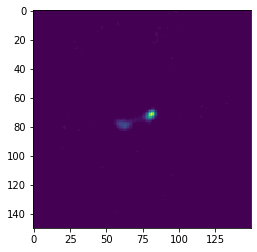

In [12]:
plt.imshow(array_train[102,0,:,:]) # Prints sample image

Creates array augmented_data to host the Augmented Data. 
- Each image is rotated at steps of 10 deg making up 19800 images for training
- The images are cut at dimension 100 pixels by 100 pixels.

In [13]:
augmented_data=np.zeros((19800,1,100,100))

In [14]:
from PIL import Image
count=0
for j in range(0,550):
    image_object=Image.fromarray(array_train[j,0,:,:])
    for i in range(0,36):
        rotated=image_object.rotate(i*10)
        imgarr = np.array(rotated)
        temp_img_array=imgarr[25:125,25:125]
        augmented_data[count,0,:,:]=temp_img_array
        count+=1

- Normalizes the imagae arrayfrom 0.0 to 1.0. Minimum parameter used for normalization is -1.0 while maximum parameter used for normalization is +1.0. If image array is not normalized between 0 and +1.0 the loss function will result runtime error

In [34]:
augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))

In [35]:
X=augmented_data

- Shuffles images in the data array

In [36]:
np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X);

# Variational Auto Encoder Neural Network 
The Variational Auto Encoder consists of two neural network: i. An encoder and ii.a decoder.  
- The Encoder\
The enncoder consists of 5 layers and an input layer. The 100 by 100 pizels are reshaped to 10000 input features that are then reduced to 4096 in the first connected layer, then to 2048 features, then to 1024 features, to 512 features, 256 features and finally to the final 2 dimensional latent space z.

In [37]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1) #x_dim=10000 to h_dim1=4096 
        self.fc2 = nn.Linear(h_dim1, h_dim2) #h_dim1=4096 to h_dim2=2048
        self.fc3 = nn.Linear(h_dim2, h_dim3) #h_dim2=2048 to h_dim3=1024
        self.fc4 = nn.Linear(h_dim3, h_dim4) #h_dim3=1024 to h_dim4=512
        self.fc5 = nn.Linear(h_dim4, h_dim5) #h_dim4=512 to h_dim5=256
        self.fc61 = nn.Linear(h_dim5, z_dim) #h_dim5=256 to z_dim=2
        self.fc62 = nn.Linear(h_dim5, z_dim) #h_dim5=256 to z_dim=2
        
        # decoder part
        self.fc7 = nn.Linear(z_dim, h_dim5) #z_dim=2 to h_dim5=256
        self.fc8 = nn.Linear(h_dim5, h_dim4) #h_dim5=256 to h_dim4=512
        self.fc9 = nn.Linear(h_dim4, h_dim3) #h_dim4=512 to h_dim3=1024
        self.fc10 = nn.Linear(h_dim3, h_dim2) #h_dim3=1024 to h_dim2=2048
        self.fc11 = nn.Linear(h_dim2, h_dim1) #h_dim2=2048 to h_dim1=4096
        self.fc12 = nn.Linear(h_dim1, x_dim)  #h_dim1=4096 to x_dim=10000
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))
        return self.fc61(h), self.fc62(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc7(z))
        h = F.relu(self.fc8(h))
        h = F.relu(self.fc9(h))
        h = F.relu(self.fc10(h))
        h = F.relu(self.fc11(h))
        return F.sigmoid(self.fc12(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 10000))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


In [38]:
# build model
vae = VAE(x_dim=10000, h_dim1= 4096, h_dim2=2048, h_dim3=1024, h_dim4=512, h_dim5=256, z_dim=2)

if torch.cuda.is_available():
    vae.cuda()

In [39]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 10000), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


In [40]:
def train(epoch):
    vae.train()
    train_loss = 0
    print("----------------------------------------------")
    print("Training Epoch:"+str(epoch))
    print("----------------------------------------------")
    data=torch.zeros(100, 1, 100, 100).cpu
    for j in range(0,198):
        data = torch.from_numpy(X[j*100:(j+1)*100,:,:])
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data.float())
        loss = loss_function(recon_batch.float(), data.float(), mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
          
        print("% Data Trained:"+str(round(((j/197.0)*100.0),1))+"%, Loss:"+str(loss.item() / len(data)))

In [41]:
for epoch in range(1, 10):
    train(epoch)

----------------------------------------------
Training Epoch:1
----------------------------------------------
% Data Trained:0.0%, Loss:6931.388125
% Data Trained:0.5%, Loss:6238.729375
% Data Trained:1.0%, Loss:3183.219375
% Data Trained:1.5%, Loss:537.2292578125
% Data Trained:2.0%, Loss:627.231015625
% Data Trained:2.5%, Loss:722.180234375
% Data Trained:3.0%, Loss:687.847734375
% Data Trained:3.6%, Loss:869.659296875
% Data Trained:4.1%, Loss:1129.873125
% Data Trained:4.6%, Loss:1456.84875
% Data Trained:5.1%, Loss:1024.0525
% Data Trained:5.6%, Loss:1163.1565625
% Data Trained:6.1%, Loss:1185.375859375
% Data Trained:6.6%, Loss:1039.26546875
% Data Trained:7.1%, Loss:1116.875546875
% Data Trained:7.6%, Loss:1015.373828125
% Data Trained:8.1%, Loss:1011.842265625
% Data Trained:8.6%, Loss:986.94
% Data Trained:9.1%, Loss:868.1834375
% Data Trained:9.6%, Loss:789.5978125
% Data Trained:10.2%, Loss:1034.817421875
% Data Trained:10.7%, Loss:612.541953125
% Data Trained:11.2%, Loss:4

% Data Trained:100.0%, Loss:181.2208984375
----------------------------------------------
Training Epoch:2
----------------------------------------------
% Data Trained:0.0%, Loss:154.548388671875
% Data Trained:0.5%, Loss:161.687353515625
% Data Trained:1.0%, Loss:155.370888671875
% Data Trained:1.5%, Loss:165.02583984375
% Data Trained:2.0%, Loss:147.7911328125
% Data Trained:2.5%, Loss:155.797216796875
% Data Trained:3.0%, Loss:147.0498046875
% Data Trained:3.6%, Loss:157.40025390625
% Data Trained:4.1%, Loss:154.1704296875
% Data Trained:4.6%, Loss:190.60283203125
% Data Trained:5.1%, Loss:147.23408203125
% Data Trained:5.6%, Loss:175.5264453125
% Data Trained:6.1%, Loss:174.0746484375
% Data Trained:6.6%, Loss:167.15669921875
% Data Trained:7.1%, Loss:173.597265625
% Data Trained:7.6%, Loss:158.231552734375
% Data Trained:8.1%, Loss:159.34408203125
% Data Trained:8.6%, Loss:160.022138671875
% Data Trained:9.1%, Loss:157.140576171875
% Data Trained:9.6%, Loss:155.812841796875
% Dat

% Data Trained:97.0%, Loss:140.754892578125
% Data Trained:97.5%, Loss:158.958837890625
% Data Trained:98.0%, Loss:166.70544921875
% Data Trained:98.5%, Loss:172.39291015625
% Data Trained:99.0%, Loss:173.56361328125
% Data Trained:99.5%, Loss:160.332236328125
% Data Trained:100.0%, Loss:179.3815234375
----------------------------------------------
Training Epoch:3
----------------------------------------------
% Data Trained:0.0%, Loss:153.004609375
% Data Trained:0.5%, Loss:160.8253515625
% Data Trained:1.0%, Loss:154.101181640625
% Data Trained:1.5%, Loss:163.532958984375
% Data Trained:2.0%, Loss:147.432763671875
% Data Trained:2.5%, Loss:154.188466796875
% Data Trained:3.0%, Loss:145.51013671875
% Data Trained:3.6%, Loss:157.418720703125
% Data Trained:4.1%, Loss:153.103798828125
% Data Trained:4.6%, Loss:188.6296484375
% Data Trained:5.1%, Loss:146.704892578125
% Data Trained:5.6%, Loss:173.1227734375
% Data Trained:6.1%, Loss:173.112578125
% Data Trained:6.6%, Loss:166.780058593

% Data Trained:93.9%, Loss:197.51595703125
% Data Trained:94.4%, Loss:155.0824609375
% Data Trained:94.9%, Loss:155.570654296875
% Data Trained:95.4%, Loss:152.76091796875
% Data Trained:95.9%, Loss:154.42158203125
% Data Trained:96.4%, Loss:181.0014453125
% Data Trained:97.0%, Loss:139.680791015625
% Data Trained:97.5%, Loss:159.722783203125
% Data Trained:98.0%, Loss:167.00296875
% Data Trained:98.5%, Loss:172.10455078125
% Data Trained:99.0%, Loss:173.7453125
% Data Trained:99.5%, Loss:160.281591796875
% Data Trained:100.0%, Loss:179.617890625
----------------------------------------------
Training Epoch:4
----------------------------------------------
% Data Trained:0.0%, Loss:153.112734375
% Data Trained:0.5%, Loss:160.60697265625
% Data Trained:1.0%, Loss:154.209921875
% Data Trained:1.5%, Loss:163.7662109375
% Data Trained:2.0%, Loss:147.136533203125
% Data Trained:2.5%, Loss:154.5501953125
% Data Trained:3.0%, Loss:145.518720703125
% Data Trained:3.6%, Loss:156.8441015625
% Dat

% Data Trained:90.9%, Loss:164.30744140625
% Data Trained:91.4%, Loss:162.56736328125
% Data Trained:91.9%, Loss:149.707607421875
% Data Trained:92.4%, Loss:167.50611328125
% Data Trained:92.9%, Loss:162.070830078125
% Data Trained:93.4%, Loss:146.29720703125
% Data Trained:93.9%, Loss:197.38193359375
% Data Trained:94.4%, Loss:155.19283203125
% Data Trained:94.9%, Loss:155.115224609375
% Data Trained:95.4%, Loss:152.27916015625
% Data Trained:95.9%, Loss:153.535390625
% Data Trained:96.4%, Loss:180.8907421875
% Data Trained:97.0%, Loss:139.8755859375
% Data Trained:97.5%, Loss:158.98708984375
% Data Trained:98.0%, Loss:166.51359375
% Data Trained:98.5%, Loss:172.01533203125
% Data Trained:99.0%, Loss:173.362109375
% Data Trained:99.5%, Loss:160.063837890625
% Data Trained:100.0%, Loss:178.47685546875
----------------------------------------------
Training Epoch:5
----------------------------------------------
% Data Trained:0.0%, Loss:153.42287109375
% Data Trained:0.5%, Loss:160.0888

% Data Trained:87.8%, Loss:174.47962890625
% Data Trained:88.3%, Loss:167.59708984375
% Data Trained:88.8%, Loss:156.453203125
% Data Trained:89.3%, Loss:196.12791015625
% Data Trained:89.8%, Loss:158.932587890625
% Data Trained:90.4%, Loss:145.042509765625
% Data Trained:90.9%, Loss:164.552890625
% Data Trained:91.4%, Loss:162.45865234375
% Data Trained:91.9%, Loss:149.14744140625
% Data Trained:92.4%, Loss:167.47138671875
% Data Trained:92.9%, Loss:162.042578125
% Data Trained:93.4%, Loss:145.67517578125
% Data Trained:93.9%, Loss:196.92607421875
% Data Trained:94.4%, Loss:154.080234375
% Data Trained:94.9%, Loss:154.8966015625
% Data Trained:95.4%, Loss:152.1010546875
% Data Trained:95.9%, Loss:153.045634765625
% Data Trained:96.4%, Loss:180.1700390625
% Data Trained:97.0%, Loss:139.542431640625
% Data Trained:97.5%, Loss:159.279375
% Data Trained:98.0%, Loss:166.31001953125
% Data Trained:98.5%, Loss:172.025546875
% Data Trained:99.0%, Loss:172.46298828125
% Data Trained:99.5%, Los

% Data Trained:84.8%, Loss:191.71162109375
% Data Trained:85.3%, Loss:151.4354296875
% Data Trained:85.8%, Loss:172.7721875
% Data Trained:86.3%, Loss:166.054375
% Data Trained:86.8%, Loss:168.7397265625
% Data Trained:87.3%, Loss:157.89552734375
% Data Trained:87.8%, Loss:175.27548828125
% Data Trained:88.3%, Loss:167.02548828125
% Data Trained:88.8%, Loss:156.330322265625
% Data Trained:89.3%, Loss:196.68552734375
% Data Trained:89.8%, Loss:158.330048828125
% Data Trained:90.4%, Loss:145.095419921875
% Data Trained:90.9%, Loss:165.14962890625
% Data Trained:91.4%, Loss:161.426611328125
% Data Trained:91.9%, Loss:148.48091796875
% Data Trained:92.4%, Loss:168.88291015625
% Data Trained:92.9%, Loss:162.200625
% Data Trained:93.4%, Loss:145.8366796875
% Data Trained:93.9%, Loss:198.54908203125
% Data Trained:94.4%, Loss:154.334443359375
% Data Trained:94.9%, Loss:155.87771484375
% Data Trained:95.4%, Loss:152.358896484375
% Data Trained:95.9%, Loss:153.394326171875
% Data Trained:96.4%,

% Data Trained:81.7%, Loss:175.95439453125
% Data Trained:82.2%, Loss:162.936748046875
% Data Trained:82.7%, Loss:160.564892578125
% Data Trained:83.2%, Loss:158.31765625
% Data Trained:83.8%, Loss:174.03080078125
% Data Trained:84.3%, Loss:160.781318359375
% Data Trained:84.8%, Loss:191.5143359375
% Data Trained:85.3%, Loss:151.347041015625
% Data Trained:85.8%, Loss:172.49857421875
% Data Trained:86.3%, Loss:165.723359375
% Data Trained:86.8%, Loss:167.625078125
% Data Trained:87.3%, Loss:157.650390625
% Data Trained:87.8%, Loss:174.69119140625
% Data Trained:88.3%, Loss:166.72486328125
% Data Trained:88.8%, Loss:155.49498046875
% Data Trained:89.3%, Loss:195.0891796875
% Data Trained:89.8%, Loss:158.348203125
% Data Trained:90.4%, Loss:145.038017578125
% Data Trained:90.9%, Loss:163.950390625
% Data Trained:91.4%, Loss:161.1237890625
% Data Trained:91.9%, Loss:148.942470703125
% Data Trained:92.4%, Loss:167.891484375
% Data Trained:92.9%, Loss:162.51734375
% Data Trained:93.4%, Loss

% Data Trained:78.7%, Loss:169.57591796875
% Data Trained:79.2%, Loss:162.155634765625
% Data Trained:79.7%, Loss:162.81619140625
% Data Trained:80.2%, Loss:171.4309765625
% Data Trained:80.7%, Loss:150.285673828125
% Data Trained:81.2%, Loss:166.61275390625
% Data Trained:81.7%, Loss:175.021796875
% Data Trained:82.2%, Loss:163.873046875
% Data Trained:82.7%, Loss:161.28291015625
% Data Trained:83.2%, Loss:157.36607421875
% Data Trained:83.8%, Loss:174.58798828125
% Data Trained:84.3%, Loss:160.5287890625
% Data Trained:84.8%, Loss:189.58533203125
% Data Trained:85.3%, Loss:152.5477734375
% Data Trained:85.8%, Loss:173.29908203125
% Data Trained:86.3%, Loss:164.92056640625
% Data Trained:86.8%, Loss:167.38041015625
% Data Trained:87.3%, Loss:159.343662109375
% Data Trained:87.8%, Loss:172.09107421875
% Data Trained:88.3%, Loss:167.99005859375
% Data Trained:88.8%, Loss:155.735478515625
% Data Trained:89.3%, Loss:195.44751953125
% Data Trained:89.8%, Loss:157.84365234375
% Data Trained

% Data Trained:75.6%, Loss:146.944189453125
% Data Trained:76.1%, Loss:144.30421875
% Data Trained:76.6%, Loss:174.11580078125
% Data Trained:77.2%, Loss:153.948037109375
% Data Trained:77.7%, Loss:164.8001953125
% Data Trained:78.2%, Loss:152.342216796875
% Data Trained:78.7%, Loss:169.9855078125
% Data Trained:79.2%, Loss:159.87701171875
% Data Trained:79.7%, Loss:157.111142578125
% Data Trained:80.2%, Loss:167.22876953125
% Data Trained:80.7%, Loss:147.0623046875
% Data Trained:81.2%, Loss:161.886328125
% Data Trained:81.7%, Loss:171.81935546875
% Data Trained:82.2%, Loss:158.73416015625
% Data Trained:82.7%, Loss:158.898408203125
% Data Trained:83.2%, Loss:154.951240234375
% Data Trained:83.8%, Loss:171.2517578125
% Data Trained:84.3%, Loss:155.60064453125
% Data Trained:84.8%, Loss:186.75390625
% Data Trained:85.3%, Loss:147.315283203125
% Data Trained:85.8%, Loss:169.70875
% Data Trained:86.3%, Loss:161.6978515625
% Data Trained:86.8%, Loss:164.1523828125
% Data Trained:87.3%, Lo

Sample the images from the latent space z, sample range between $-4.0 \leqslant z_1 \leqslant 4.0$ and $-4.0 \leqslant z_2 \leqslant 4.0$. Image are sampled at steps of 0.2 in both directions.

In [ ]:
with torch.no_grad():
    z = torch.randn(1600, 2).cuda()
    count_x=-4.0
    count_y=-4.0
    x=0
    y=0
    for i in range (0,40):
        for j in range (0,40):
            z[x,0]=count_x
            z[x,1]=count_y
            x=x+1
            count_y=count_y+0.2
        y=y+1
        count_x=count_x+0.2
        count_y=-4.0
        
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(1600, 1, 100, 100), 'sample_z_space_' +str(epoch)+'.png',nrow=40)

In [33]:
with torch.no_grad():
    z = torch.randn(100, 2).cuda()    
    sample = vae.decoder(z).cuda()
    save_image(sample.view(100, 1, 100, 100), 'sample_random_' +str(epoch)+'.png',nrow=10)